In [2]:
import os
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from glob import glob
import time
from tqdm import tqdm
from sklearn import metrics
import cv2
import gc
import torch.nn.functional as F
from glob import glob
# from sklearn.model_selection import GroupKFold
from datetime import datetime
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn

In [3]:
SEED = 42
def seed_everything(seed):
    print(f'setting everything to seed {seed}')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

setting everything to seed 42


# Dataset

In [4]:
path = 'two-spiral traing data(update).txt'
with open(path,'r') as f:
    traindata = f.readlines()

In [5]:
train_df = pd.DataFrame(columns=['x','y','label'])

In [6]:
x = []
y = []
label = []
for line in traindata:
    temp = line.strip().split()
    x.append(float(temp[0]))
    if len(temp)==4 :
        y.append(float(temp[2]))
        label.append(float(temp[3]))
    else:
        y.append(float(temp[1]))
        label.append(float(temp[2]))
train_df['x'] = x
train_df['y'] = y
train_df['label'] = label

In [7]:
# 随机选择30个进行测试
random = np.random.randint(0,193,30)
train_df['type'] = 'train'
train_df.loc[random,'type'] = 'test'

In [8]:
def normalize(train_df):
    datas = train_df[['x','y']].values
    x,y = datas[:,0],datas[:,1]
    xmax = np.max(x)
    xmin = np.min(x)
    ymax = np.max(y)
    ymin = np.min(y)
    x = (x-xmin)/(xmax-xmin)
    y = (y-ymin)/(ymax-ymin)
    datas[:,0] = x
    datas[:,1] = y
    return datas
train_df['norm_x'] = 0
train_df['norm_y'] = 0
train_df.loc[range(194), ['norm_x','norm_y']] = normalize(train_df[['x','y']])

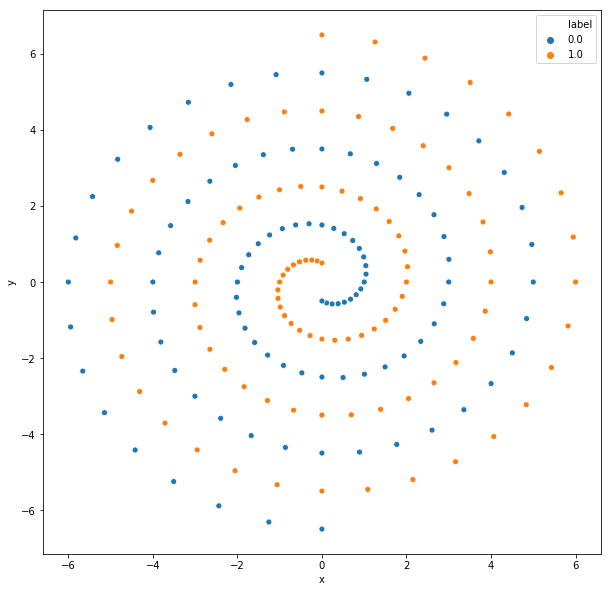

In [9]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.scatterplot(data=train_df,x='x',y='y',hue="label")

In [10]:
class MyDataset(Dataset):
    def __init__(self,data_df,mode='train'):
        super().__init__()
        self.data_df = data_df[data_df.type==mode].reset_index()
        self.mode = mode
        self.x = self.data_df['x'].values
        self.y = self.data_df['y'].values
        self.label = self.data_df['label'].values
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        label = self.label[index]
        return np.array([x,y]),label
    def __len__(self) -> int:
        return len(self.x)

In [11]:
# 多层感知机测试数据是否容易划分
class MLP(nn.Module):
    def __init__(self,num_class=1):
        super().__init__()
        self.fc = nn.Linear(2,32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,1)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.fc(x)
        x = x.tanh()
        x = self.fc2(x)
        x = x.tanh()
        out = torch.sigmoid(self.fc3(x))
        return out
    def init_params(self):
        for param in self.parameters():
            nn.init.normal_(param,mean=0,std=0.01)
            
class MLPQ(nn.Module):
    def __init__(self,num_class=1):
        super().__init__()
        self.u1 = nn.Linear(2,32,bias=True)
        self.v1 = nn.Linear(2,32,bias=True)
        self.u2 = nn.Linear(32,num_class,bias=True)
        self.v2 = nn.Linear(32,num_class,bias=True)

    def forward(self,x):
        x = x.float()
        x_2 = x*x
        x1 = self.u1(x_2)
        x2 = self.v1(x)
        x = x1+x2
        x = x.sigmoid()
        x_2 = x*x
        x1 = self.u2(x_2)
        x2 = self.v2(x)
        x = x1+x2
        out = x.sigmoid()
        return out

In [311]:
from tqdm import tqdm_notebook
import time
start=time.time()
# online learning
batch_size = 1
# 0 for windows otherwise error
num_workers = 0
lr = 0.01
train_dataset = MyDataset(train_df,mode='train')
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=False)
test_data = MyDataset(train_df,mode='test')
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=False)
device = 'cpu'
model = MLPQ()
# 初始化参数
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model = model.to(device)
criterion = torch.nn.BCELoss()
num_epochs = 10000
train_loss = []
test_loss = []
early_stop = 500
best_score = -1
ct = 0
for epoch in range(num_epochs):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     optimizer = torch.optim.Adam(model.parameters(),eps=0.000001,lr=lr,
#                                  betas=(0.9,0.999),weight_decay=1e-6)
#     tk = tqdm_notebook(train_loader, total=int(len(train_loader)))
#     ts = tqdm_notebook(test_loader, total=int(len(test_loader)))
    running_loss = 0
    loss_temp = 0
#     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    acc = 0
    preds = []
    lbs = []
    # 训练
    model.train()
    for kk,(inputs,label) in enumerate(train_loader):
        inputs = inputs.to(device,dtype=torch.float)
        label = label.to(device, dtype=torch.float)
        label = label.reshape(-1,1)
        outputs = model(inputs)
#         print(outputs)
        loss = criterion(outputs, label)
        loss.backward()
#         print(loss)
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        loss_temp += loss.item()
#         tk.set_postfix(loss=(loss_temp/(kk+1)))
        preds.extend(list(outputs.data.numpy()))
        lbs.extend(list(label.numpy()))
    epoch_loss = running_loss / (len(train_loader)/batch_size)
    train_loss.append(epoch_loss)
    if epoch%100==0:
        print('Training Loss: {:.5f}'.format(epoch_loss))
        # 计算ACC
        preds = np.array(preds)
        lbs = np.array(lbs)
        preds = preds>=0.5
        acc = np.sum(lbs==preds)/len(lbs)
        print('Training acc: {:.5f}'.format(acc))
    
    # 测试 / 验证
    test_running_loss = 0
    test_acc = 0
    test_preds = []
    test_lbs = []
    for kk,(inputs,label) in enumerate(test_loader):
        model.eval()
        inputs = inputs.to(device,dtype=torch.float)
        label = label.to(device, dtype=torch.float)
        label = label.reshape(-1,1)
        outputs = model(inputs)
        loss = criterion(outputs, label)
        test_running_loss += loss.item()
        test_preds.extend(list(outputs.data.numpy()))
        test_lbs.extend(list(label.numpy()))
    test_epoch_loss = test_running_loss / (len(test_loader)/batch_size)
    test_loss.append(test_epoch_loss)
    test_preds = np.array(test_preds)
    test_lbs = np.array(test_lbs)
    test_preds = test_preds>=0.5
    acc = np.sum(test_lbs==test_preds)/len(test_lbs)
    if epoch%100==0:
        print('Testing Loss: {:.5f}'.format(test_epoch_loss))
        print('Testing acc: {:.5f}'.format(acc))
    if acc>best_score:
        ct = 0
        best_score = acc
    else:
        ct+=1
    if ct>=early_stop:
        print('early_stop---------------')
        break
    if acc==1:
        print(f'epoch:{epoch} acc is 100%')
        break
end=time.time()
print('Running time: %s Seconds'%(end-start))

Training Loss: 0.83995
Training acc: 0.30120
Testing Loss: 0.68631
Testing acc: 0.46429
Training Loss: 0.70028
Training acc: 0.66265
Testing Loss: 1.29942
Testing acc: 0.46429
Training Loss: 0.69020
Training acc: 0.72289
Testing Loss: 0.67429
Testing acc: 0.60714
Training Loss: 0.59891
Training acc: 0.77108
Testing Loss: 0.39376
Testing acc: 0.75000
Training Loss: 0.35791
Training acc: 0.80723
Testing Loss: 0.47655
Testing acc: 0.75000
Training Loss: 0.26926
Training acc: 0.84337
Testing Loss: 0.33832
Testing acc: 0.75000
Training Loss: 0.49960
Training acc: 0.84940
Testing Loss: 0.75670
Testing acc: 0.82143
Training Loss: 0.31085
Training acc: 0.90964
Testing Loss: 0.72615
Testing acc: 0.82143
epoch:723 acc is 100%
Running time: 225.49089431762695 Seconds


In [18]:
# 画出分割面  512*512
dx = np.linspace(-6, 6, 64)
dy = np.linspace(-6.5, 6.5, 64)
image = np.zeros((64,64))

In [17]:
def bound(model):
    for i,y in enumerate(dy):
        test_preds = []
        model.eval()
        for x in dx:
            inputs = torch.tensor(np.array([x,y]))
            inputs = inputs.to(device,dtype=torch.float)
            outputs = model(inputs)
            test_preds.extend(list(outputs.data.numpy()))
        test_preds = np.array(test_preds)
        test_preds = test_preds>=0.5
        image[i] = test_preds
    plt.imshow(image)

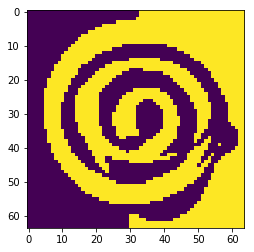

In [316]:
bound(model)

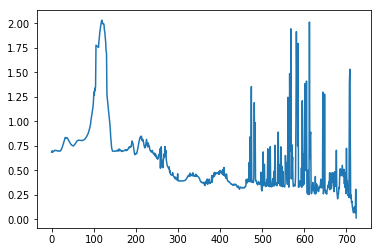

In [317]:
plt.plot(test_loss)

In [90]:
# 去掉测试数据
train_df['type'] = 'train'
from tqdm import tqdm_notebook
import time
start=time.time()
# online learning
batch_size = 1
# 0 for windows otherwise error
num_workers = 0
lr = 0.001
train_dataset = MyDataset(train_df,mode='train')
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)
device = 'cpu'
model = MLPQ()
# 初始化参数
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model = model.to(device)
criterion = torch.nn.BCELoss()
num_epochs = 10000
train_loss = []
test_loss = []
early_stop = 500
best_score = -1
ct = 0
for epoch in range(num_epochs):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_loss = 0
    loss_temp = 0
#     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    acc = 0
    preds = []
    lbs = []
    # 训练
    model.train()
    for kk,(inputs,label) in enumerate(train_loader):
        inputs = inputs.to(device,dtype=torch.float)
        label = label.to(device, dtype=torch.float)
        label = label.reshape(-1,1)
        outputs = model(inputs)
#         print(outputs)
        loss = criterion(outputs, label)
        loss.backward()
#         print(loss)
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        loss_temp += loss.item()
#         tk.set_postfix(loss=(loss_temp/(kk+1)))
        preds.extend(list(outputs.data.numpy()))
        lbs.extend(list(label.numpy()))
    epoch_loss = running_loss / (len(train_loader)/batch_size)
    train_loss.append(epoch_loss)
    if epoch%100==0:
        print('Training Loss: {:.5f}'.format(epoch_loss))
        # 计算ACC
        preds = np.array(preds)
        lbs = np.array(lbs)
        preds = preds>=0.5
        acc = np.sum(lbs==preds)/len(lbs)
        print('Training acc: {:.5f}'.format(acc))
    
    if acc>best_score:
        ct = 0
        best_score = acc
    else:
        ct+=1
    if ct>=early_stop:
        print('early_stop---------------')
        break
    if acc==1:
        print(f'epoch:{epoch} acc is 100%')
        break
end=time.time()
print('Running time: %s Seconds'%(end-start))

Training Loss: 0.94200
Training acc: 0.49485
Training Loss: 0.61979
Training acc: 0.65979
Training Loss: 0.50187
Training acc: 0.69072
Training Loss: 0.42169
Training acc: 0.71134
Training Loss: 0.37919
Training acc: 0.75773
Training Loss: 0.34938
Training acc: 0.77320
Training Loss: 0.27590
Training acc: 0.79381
Training Loss: 0.16939
Training acc: 0.95361
Training Loss: 0.06924
Training acc: 0.99485
Training Loss: 0.02538
Training acc: 0.99485
Training Loss: 0.00979
Training acc: 1.00000
epoch:1000 acc is 100%
Running time: 284.97875905036926 Seconds


In [26]:
test_preds = []
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=False)
for kk,(inputs,label) in enumerate(train_loader):
    inputs = inputs.to(device,dtype=torch.float)
    outputs = model(inputs)
    test_preds.extend(list(outputs.data.numpy()))
test_preds = np.array(test_preds)
test_preds = test_preds>=0.5
train_df['pred'] = test_preds.astype(np.int)

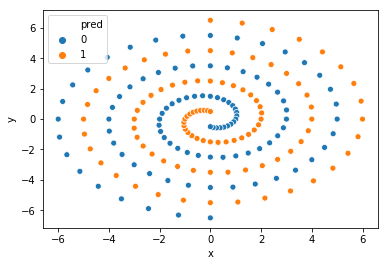

In [27]:
sns.scatterplot(data=train_df,x='x',y='y',hue="pred")

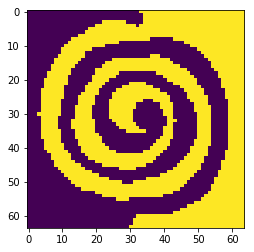

In [28]:
bound(model)

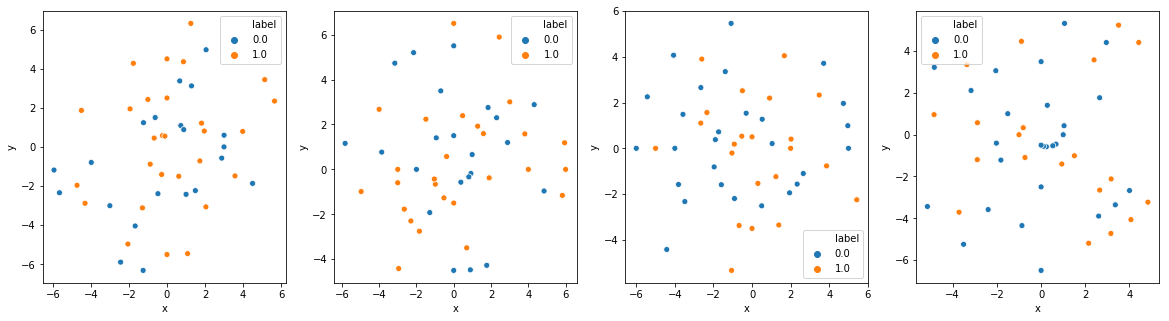

In [29]:
# 最小最大化网络
# 随机分成4份
train_df_split = train_df.copy()
import random
indexs = list(range(194))
random.shuffle(indexs)
for i in range(0,194,49):
    tempindex = indexs[i:i+49]
    train_df_split.loc[tempindex,'split'] = i//49
# plot
plt.figure(figsize=(20,5))
for i in range(1,5):
    plt.subplot(1, 4, i)
    sns.scatterplot(data=train_df_split[train_df_split.split==i-1],x='x',y='y',hue="label")

In [83]:
class MAX_MIN_MLPQ(nn.Module):
    
    def __init__(self,num_class=1,hidden=32):
        super().__init__()
        layeru = nn.Linear(2,hidden,bias=True)
        layeru2 = nn.Linear(hidden,num_class,bias=True)
        for i in range(4):
            setattr(self, f"linear_hidden_u{i}", layeru)
            setattr(self, f"linear_hidden_v{i}", layeru)
            setattr(self, f"linear_final_u{i}", layeru2)
            setattr(self, f"linear_final_v{i}", layeru2)
    
    def forward(self,x):
        # 训练时输入: x   batch_size*4*2 4个不同输入
        # 预测时输入: x   batch_size*4*2 4个相同输入
        # 输入: x   1*4*2
        # 产生4个输出 四个网络同时训练
        inputs = x
        out = []
        for i in range(4):
            x = inputs[:,i,]
            # x.shape is batchsize*2
            x = x.float()
            x_2 = x*x
            x1 = getattr(self, f"linear_hidden_u{i}")(x_2)
            x2 = getattr(self, f"linear_hidden_v{i}")(x)
            x = x1+x2
            x = x.sigmoid()
            x_2 = x*x
            x1 = getattr(self, f"linear_final_u{i}")(x_2)
            x2 = getattr(self, f"linear_final_v{i}")(x)
            x = x1+x2
            x = x.sigmoid()
            out.append(x)
        if self.training:
            return torch.cat(out,dim=0)
        # 预测
        x1,x2,x3,x4 = out[0],out[1],out[2],out[3]
        max1 = torch.min(x1,x2)
        max2 = torch.min(x3,x4)
        out = torch.max(max1,max2)
        return out

In [72]:
class MySplitDataset(Dataset):
    '''
    params: data_df split
    '''
    def __init__(self,data_df,split_num=4,mode='train'):
        super().__init__()
        self.data_df = data_df[data_df.type==mode].reset_index()
        self.len = data_df[data_df.split==split_num-1].shape[0]
        self.mode = mode
        self.x = []
        self.y = []
        self.label = []
        self.split_num = split_num
        for i in range(split_num):
            self.x.append(self.data_df[data_df.split==i]['x'].values)
            self.y.append(self.data_df[data_df.split==i]['y'].values)
            self.label.append(self.data_df[data_df.split==i]['label'].values)
        
    def __getitem__(self, index):
        res = []
        label = []
        for i in range(self.split_num):
            res.append([self.x[i][index],self.y[i][index]])
            label.append(self.label[i][index])
        return np.array(res),np.array(label)
    def __len__(self) -> int:
        return self.len

In [73]:
from tqdm import tqdm_notebook
# online learning
batch_size = 1
# 0 for windows otherwise error
num_workers = 0
lr = 0.01
train_dataset = MySplitDataset(train_df_split,mode='train')
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)
device = 'cpu'
model = MAX_MIN_MLPQ()
# 初始化参数
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
model = model.to(device)
criterion = torch.nn.BCELoss()
num_epochs = 10000
train_loss = []
test_loss = []
early_stop = 20
best_score = -1
ct = 0
for epoch in range(num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_loss = 0
    loss_temp = 0
#     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    acc = 0
    preds = []
    lbs = []
    # 训练
    model.train()
    for kk,(inputs,label) in enumerate(train_loader):
        inputs = inputs.to(device,dtype=torch.float)
        label = label.to(device, dtype=torch.float)
        label = label.reshape(-1,1)
        outputs = model(inputs)
        loss = criterion(outputs, label)
        loss.backward()
#         print(loss)
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        loss_temp += loss.item()
#         tk.set_postfix(loss=(loss_temp/(kk+1)))
        preds.extend(list(outputs.data.numpy()))
        lbs.extend(list(label.numpy()))
    epoch_loss = running_loss / (len(train_loader)/batch_size)
    train_loss.append(epoch_loss)
    if epoch%100==0:
        print('Training Loss: {:.5f}'.format(epoch_loss))
        # 计算ACC
        preds = np.array(preds)
        lbs = np.array(lbs)
        preds = preds>=0.5
        acc = np.sum(lbs==preds)/len(lbs)
        print('Training acc: {:.5f}'.format(acc))

Training Loss: 0.75332
Training acc: 0.46809
Training Loss: 0.52811
Training acc: 0.72340
Training Loss: 0.43707
Training acc: 0.76596
Training Loss: 0.42014
Training acc: 0.74468
Training Loss: 0.40651
Training acc: 0.77660
Training Loss: 0.45099
Training acc: 0.75000
Training Loss: 0.40667
Training acc: 0.77128
Training Loss: 0.39795
Training acc: 0.77660
Training Loss: 0.39737
Training acc: 0.79255
Training Loss: 0.39319
Training acc: 0.78191
Training Loss: 0.39294
Training acc: 0.77660
Training Loss: 0.40321
Training acc: 0.75000
Training Loss: 0.40310
Training acc: 0.75000
Training Loss: 0.39700
Training acc: 0.79255
Training Loss: 0.37841
Training acc: 0.76596
Training Loss: 0.36784
Training acc: 0.77660
Training Loss: 0.39047
Training acc: 0.79255
Training Loss: 0.38479
Training acc: 0.79255
Training Loss: 0.38107
Training acc: 0.75532
Training Loss: 0.38700
Training acc: 0.77128
Training Loss: 0.38374
Training acc: 0.76596
Training Loss: 0.38112
Training acc: 0.77128


KeyboardInterrupt: 

In [74]:
def bound2(model):
    dx = np.linspace(-6, 6, 64)
    dy = np.linspace(-6.5, 6.5, 64)
    image = np.zeros((64,64))
    for i,y in enumerate(dy):
        test_preds = []
        model.eval()
        for x in dx:
            inputs = torch.tensor(np.array([x,y]))
            inputs = inputs.repeat(1,4,1)
            inputs = inputs.to(device,dtype=torch.float)
            outputs = model(inputs)
            test_preds.extend(list(outputs.data.numpy()))
        test_preds = np.array(test_preds)
        test_preds = test_preds>=0.5
        image[i] = test_preds.reshape(-1)
    plt.imshow(image)

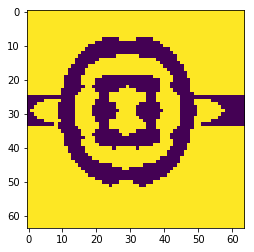

In [75]:
bound2(model)

In [76]:
train_df_prior = train_df.copy()
a = train_df_prior.x.values
b = train_df_prior.y.values
d = np.sqrt(a*a + b*b)

In [77]:
train_df_prior['distant'] = d

In [78]:
'''
0,2
2,4
3,6
6,..
'''
def mapsplit(x):
    if x>=0 and x<=2:
        return 0
    elif x<=4:
        return 1
    elif x<=6:
        return 2
    else:
        return 3

In [79]:
train_df_prior['split'] = train_df_prior['distant'].map(mapsplit)

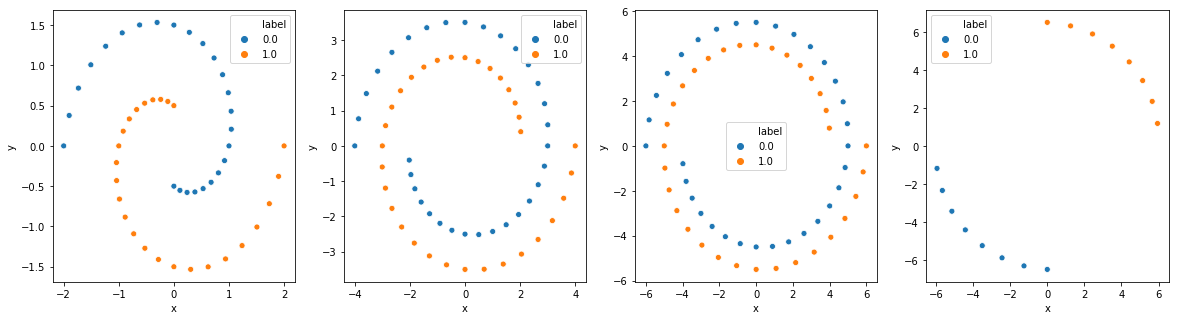

In [80]:
# plot
plt.figure(figsize=(20,5))
for i in range(1,5):
    plt.subplot(1, 4, i)
    sns.scatterplot(data=train_df_prior[train_df_prior.split==i-1],x='x',y='y',hue="label")

In [87]:
from tqdm import tqdm_notebook
# online learning
batch_size = 1
# 0 for windows otherwise error
num_workers = 0
lr = 0.01
train_dataset = MySplitDataset(train_df_prior,mode='train')
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)
device = 'cpu'
model = MAX_MIN_MLPQ(hidden=64)
# 初始化参数
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
model = model.to(device)
criterion = torch.nn.BCELoss()
num_epochs = 10000
train_loss = []
test_loss = []
early_stop = 20
best_score = -1
ct = 0
for epoch in range(num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_loss = 0
    loss_temp = 0
#     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    acc = 0
    preds = []
    lbs = []
    # 训练
    model.train()
    for kk,(inputs,label) in enumerate(train_loader):
        inputs = inputs.to(device,dtype=torch.float)
        label = label.to(device, dtype=torch.float)
        label = label.reshape(-1,1)
        outputs = model(inputs)
#         print(outputs)
        loss = criterion(outputs, label)
        loss.backward()
#         print(loss)
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        loss_temp += loss.item()
#         tk.set_postfix(loss=(loss_temp/(kk+1)))
        preds.extend(list(outputs.data.numpy()))
        lbs.extend(list(label.numpy()))
    epoch_loss = running_loss / (len(train_loader)/batch_size)
    train_loss.append(epoch_loss)
    if epoch%100==0:
        print('Training Loss: {:.5f}'.format(epoch_loss))
        # 计算ACC
        preds = np.array(preds)
        lbs = np.array(lbs)
        preds = preds>=0.5
        acc = np.sum(lbs==preds)/len(lbs)
        print('Training acc: {:.5f}'.format(acc))

Training Loss: 0.78739
Training acc: 0.46875
Training Loss: 0.71976
Training acc: 0.56250
Training Loss: 0.64341
Training acc: 0.62500
Training Loss: 0.56161
Training acc: 0.65625
Training Loss: 0.55405
Training acc: 0.71875
Training Loss: 0.45387
Training acc: 0.79688
Training Loss: 0.47720
Training acc: 0.68750
Training Loss: 0.43375
Training acc: 0.81250
Training Loss: 0.35137
Training acc: 0.84375
Training Loss: 0.36250
Training acc: 0.85938
Training Loss: 0.43243
Training acc: 0.81250
Training Loss: 0.33311
Training acc: 0.87500
Training Loss: 0.34399
Training acc: 0.87500
Training Loss: 0.30275
Training acc: 0.82812
Training Loss: 0.25608
Training acc: 0.87500
Training Loss: 0.35001
Training acc: 0.85938
Training Loss: 0.34213
Training acc: 0.85938
Training Loss: 0.26949
Training acc: 0.89062
Training Loss: 0.38008
Training acc: 0.87500
Training Loss: 0.28863
Training acc: 0.87500
Training Loss: 0.31370
Training acc: 0.85938
Training Loss: 0.31085
Training acc: 0.81250
Training L

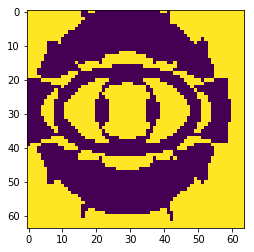

In [88]:
bound2(model)

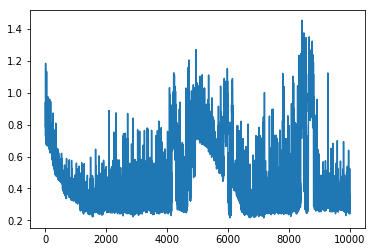

In [89]:
plt.plot(train_loss)